This Notebook Shows the Inscreased difficulty of Forecasting a Chaotic Time Series in contrast to a stable one. 
Here we implement a one step ahead LSTM model to forecast the discrete Logistic Map with stable and chaotic dynamics in a low data and noise free environment. Even at this low forecast horizon the effect of chaos is evident with training and test error being larger than the stable alternatives. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from simulate_data import LogisticMapSimulator

In [2]:
observation_noise = 0
num_timesteps = 200 # 100 burn in 
num_replications = 10
lag = 10
split = split = int(0.8 * (num_timesteps-100))

In [3]:
class LSTM(nn.Module):
    """LSTM model for time series forecasting."""
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(32, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(x)
        x = self.linear(x)
        return x


In [4]:
class MultiStepLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(MultiStepLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=False)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, future_steps):
        """
        Parameters:
            x (torch.Tensor): Input sequence of shape (seq_len, batch, input_size).
            future_steps (int): Number of future steps to predict.
        
        Returns:
            torch.Tensor: Predicted sequence of shape (future_steps, batch, output_size).
        """
        outputs = []
        h_t, c_t = None, None

        for _ in range(x.size(0) + future_steps):
            lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
            x = self.relu(lstm_out)
            output = self.linear(x)
            outputs.append(output)

        return torch.stack(outputs[-future_steps:], dim=0)


In [5]:
def create_dataset(dataset, lag):
    """
    Create input-output pairs for training an LSTM model.

    Parameters:
        dataset (numpy.ndarray): The input time series data.
        lag (int): The lag or lookback period for creating input sequences.

    Returns:
        torch.Tensor: Input sequences (X).
        torch.Tensor: Target sequences (y).
    """
    X, y = [], []
    for i in range(len(dataset)-lag):
        feature = dataset[i:i+lag]
        target = dataset[i+1:i+lag+1]
        X.append(feature)
        y.append(target)
    
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return torch.tensor(X), torch.tensor(y)


def evaluate_model(model, X, y, loss_fn):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        rmse = np.sqrt(loss_fn(y_pred, y))
    return rmse.item()

def train_model(model, loader, optimizer, loss_fn, X_train, y_train, X_test, y_test, n_epochs=700, validation_frequency=10):
    train_errors = []  
    test_errors = []   

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % validation_frequency == 0:
            model.eval()
            with torch.no_grad():
                train_rmse = evaluate_model(model, X_train, y_train, loss_fn)  
                test_rmse = evaluate_model(model, X_test, y_test, loss_fn)  

            train_errors.append(train_rmse)
            test_errors.append(test_rmse)

    return train_errors, test_errors


def simulate_and_train(r_value, obs_value, num_timesteps, lag, split):
    logistic_simulator = LogisticMapSimulator(r_value, obs_value, num_timesteps)
    values = logistic_simulator.simulate()

    X, y = create_dataset(values, lag)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    train_dataset = data.TensorDataset(X_train, y_train)
    train_loader = data.DataLoader(train_dataset, shuffle=False, batch_size=10)

    model = LSTM()
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    
    train_errors, test_errors = train_model(model, train_loader, optimizer, loss_fn, X_train, y_train, X_test, y_test)
    
    return train_errors, test_errors  # Return the final test error


In [6]:
# Experiment loop

experiment_results = []

for r in [4, 3, 2]: #r is growth rate parameter 
    all_train_errors = []  
    all_test_errors = []   

    
    for _ in range(num_replications):
        train_errors, test_errors = simulate_and_train(r, observation_noise, num_timesteps, lag, split)
        all_train_errors.append(train_errors)
        all_test_errors.append(test_errors)

    
    avg_train_errors = np.mean(np.array(all_train_errors), axis=0)
    avg_test_errors = np.mean(np.array(all_test_errors), axis=0)

    experiment_results.append((r, avg_train_errors, avg_test_errors))

Last Epoch Train RMSE for r=4: 0.0237
Last Epoch Test RMSE for r=4: 0.0879
Last Epoch Train RMSE for r=3: 0.0063
Last Epoch Test RMSE for r=3: 0.0055
Last Epoch Train RMSE for r=2: 0.0001
Last Epoch Test RMSE for r=2: 0.0001


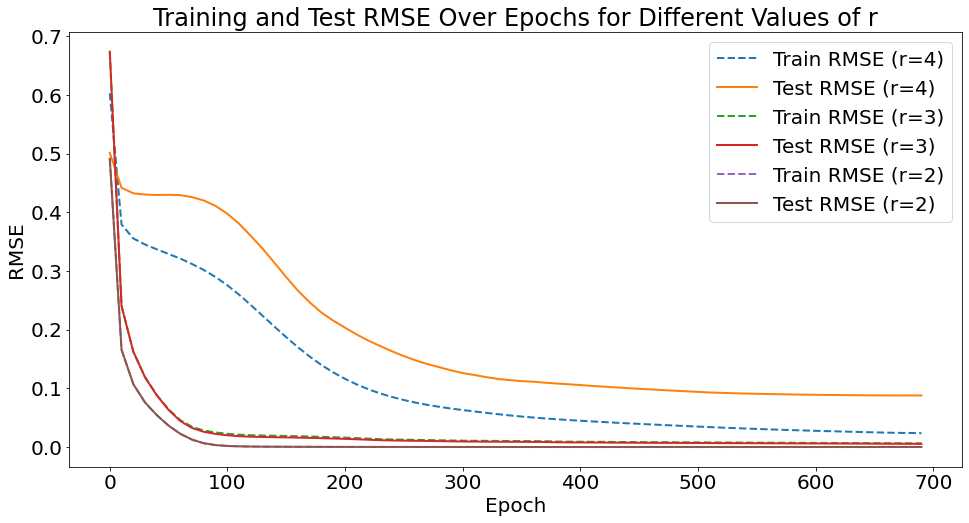

In [7]:

plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 20})

for r, avg_train_errors, avg_test_errors in experiment_results:
    last_epoch_train_rmse = avg_train_errors[-1]
    last_epoch_test_rmse = avg_test_errors[-1]

    print(f"Last Epoch Train RMSE for r={r}: {last_epoch_train_rmse:.4f}")
    print(f"Last Epoch Test RMSE for r={r}: {last_epoch_test_rmse:.4f}")

   
    epochs = np.arange(0, 700, 10)
    plt.plot(epochs, avg_train_errors, label=f'Train RMSE (r={r})', linestyle='--',linewidth=2)
    plt.plot(epochs, avg_test_errors, label=f'Test RMSE (r={r})', linestyle='-',linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Test RMSE Over Epochs for Different Values of r')
plt.legend()
plt.show()
